## Settings

In [114]:
import os
from os.path import join as osj
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import json
from workoutdetector.datasets import RepcountHelper

In [177]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.autolayout'] = True
plt.style.use('seaborn-dark')
plt.rcParams['lines.linewidth'] = 0.8
COLORS = list(plt.get_cmap('Set3').colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'

## Image model

In [3]:
json_files = [x for x in os.listdir('../out/pred_no_bbox/') if x.endswith('.json')]
json_iter = iter(json_files)

In [6]:
helper = RepcountHelper('../data/RepCount/', '../data/RepCount/annotation.csv') 
info = helper.get_rep_data(['test', 'val'], action=['all'])

stu6_30.mp4
total frames 1229
reps [102, 181, 187, 263]


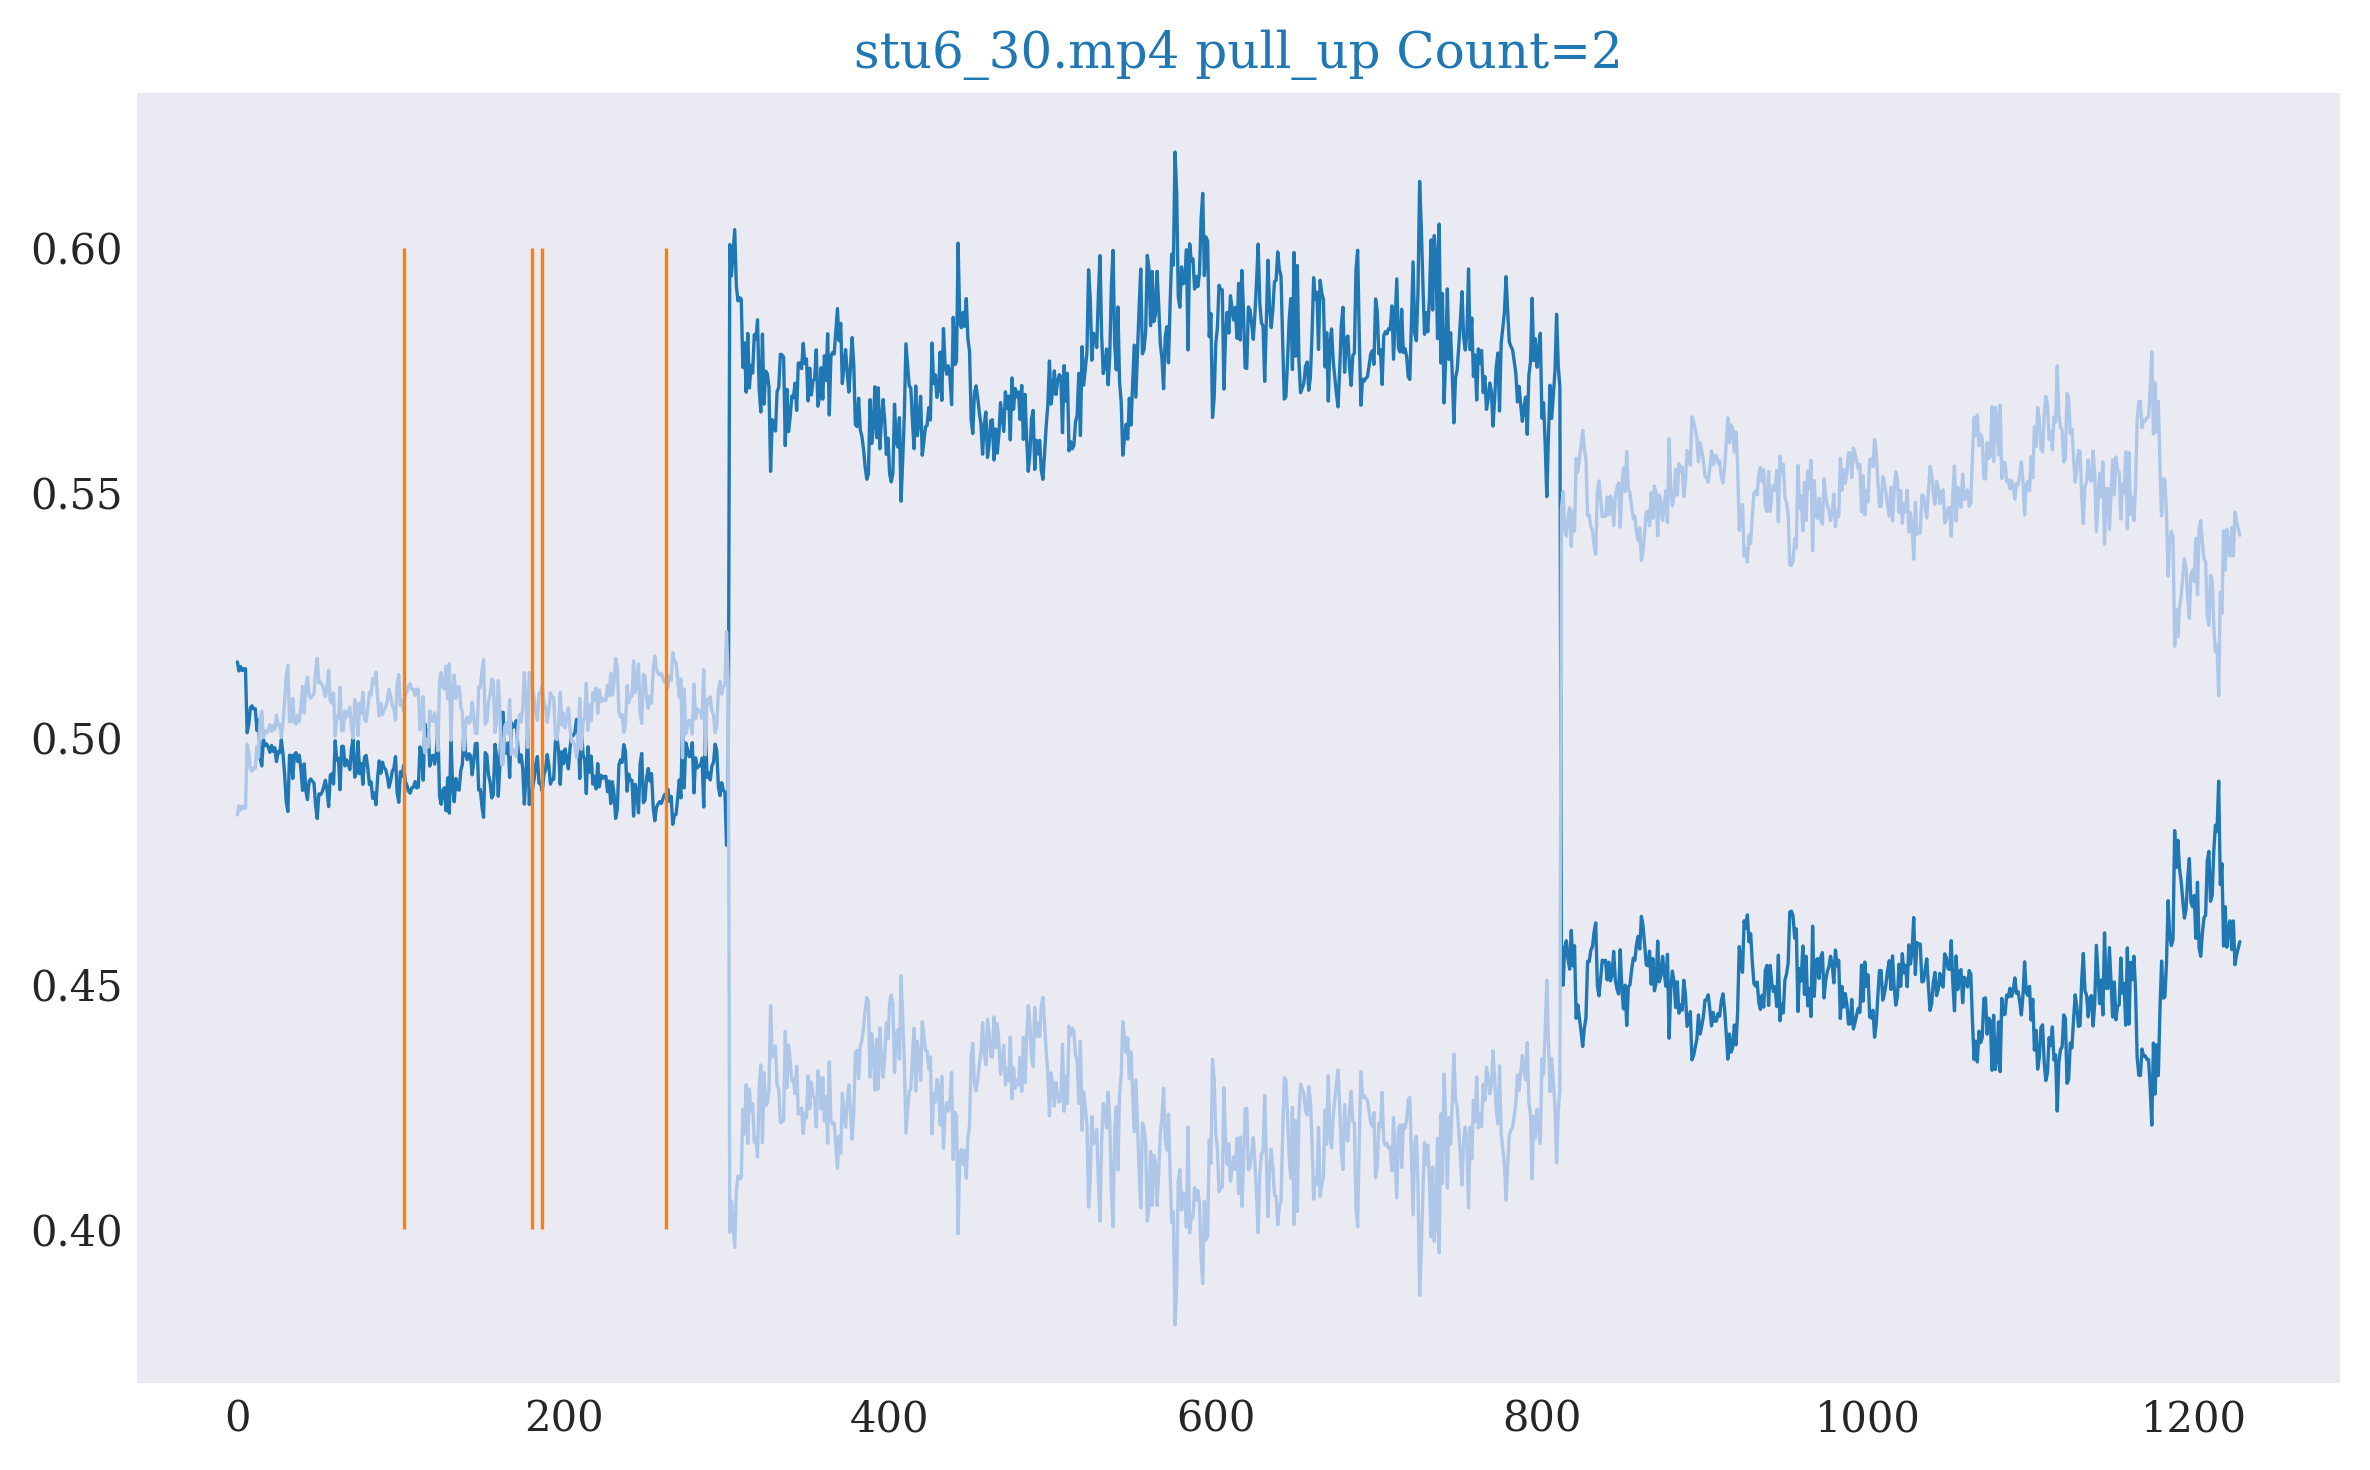

In [7]:
json_file = next(json_iter)
name = json_file.split('-')[0]
print(name)
example = json.load(open(f'../out/pred_no_bbox/{name}-score.json'))
scores = np.asarray([v for _, v in example['scores'].items()])
print('total frames', len(scores))
print('reps', info[name].reps)

plt.plot(F.softmax(torch.Tensor(scores), dim=1))
plt.vlines(x=info[name].reps, color='C2', ymin=0.4, ymax=0.6)
plt.title(f'{name} {info[name].class_} Count={info[name].count}', color='C0', fontsize=12)
plt.show()

## Video model

In [8]:
video_save_dir = '../out/tsm_rep_scores_dense_sample'
video_json = os.listdir(video_save_dir)
print(video_json[0])
video_iter = iter(video_json)

stu6_25.mp4.score.json


In [9]:
CLASSES = helper.classes
print(CLASSES)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


### Label

In [10]:
x = next(video_iter)
j = json.load(open(osj(video_save_dir, x)))
scores = np.asarray(list(j['scores'].values()))
scores

array([3, 8, 6, 8, 8, 6, 6, 6, 7, 7, 6, 7, 7, 6, 6, 7, 7, 8, 6, 6, 7, 7,
       6, 6, 7, 7, 6, 6, 7, 6, 6, 7, 7, 6, 8, 6, 6, 7, 6, 6, 6, 7, 7, 6,
       7, 7, 6, 7, 7, 7, 8, 6, 6, 7, 7, 6, 6, 7, 7, 6, 7, 7, 6, 6, 7, 7,
       8, 6, 6, 7, 7, 6, 6, 7, 6, 6, 7, 7, 6, 7, 7, 7, 8, 6, 6, 7, 7, 6,
       7, 7, 6, 6, 7, 7, 6, 7, 7, 7, 8, 8, 6, 6, 7, 6, 6, 7, 7, 6, 6, 7,
       7, 6, 7, 7, 6, 8, 6, 6, 7, 7, 6, 6, 7, 6, 6, 7, 7, 6, 6, 7, 7, 8,
       8, 6, 6, 7, 6, 6, 7, 7, 6, 7, 7, 6, 6, 7, 7, 8, 6, 6])

### Scores

sparse sample is sampling 8 frames from 16 frames uniformly. Step is 8.

In [11]:
video_save_dir = '../out/tsm_rep_scores_sparse_sample'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(valtest)

stu6_25.mp4.score.json


In [188]:
x = next(video_iter)
json_path = x.video_name + '.score.json'
j = json.load(open(osj(video_save_dir, json_path)))
print(j['video_name'])

stu10_44.mp4


(35, 12) 280


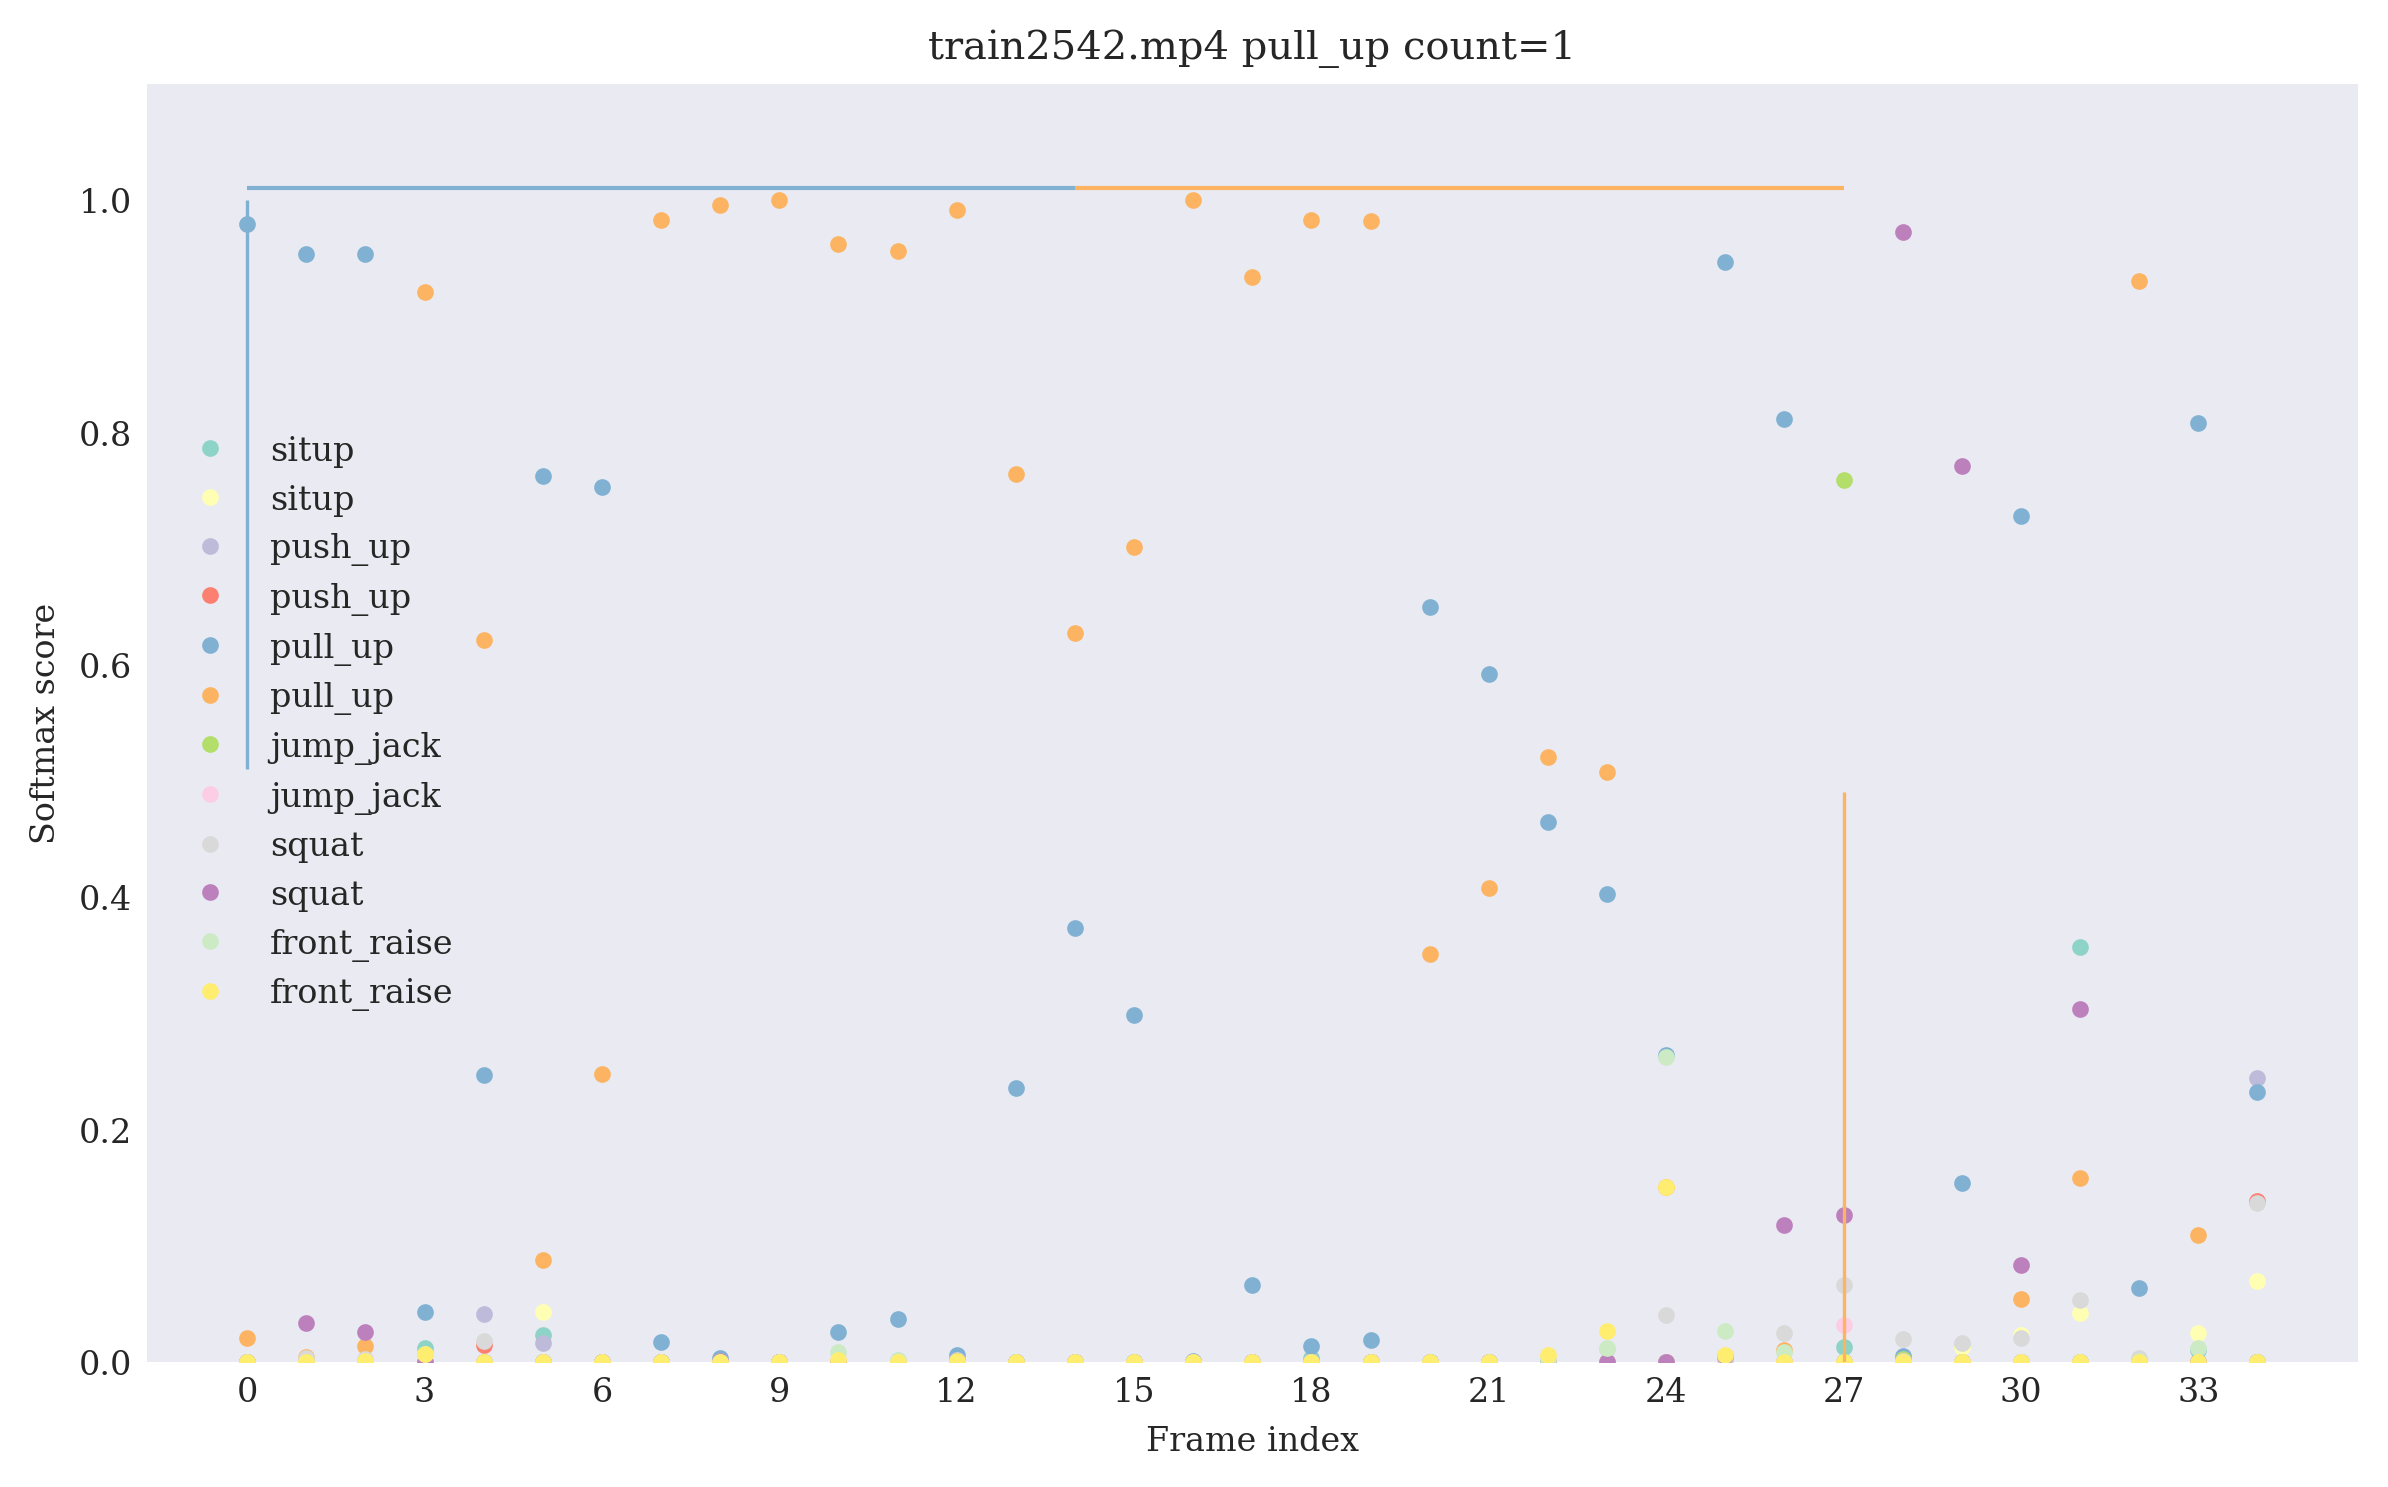

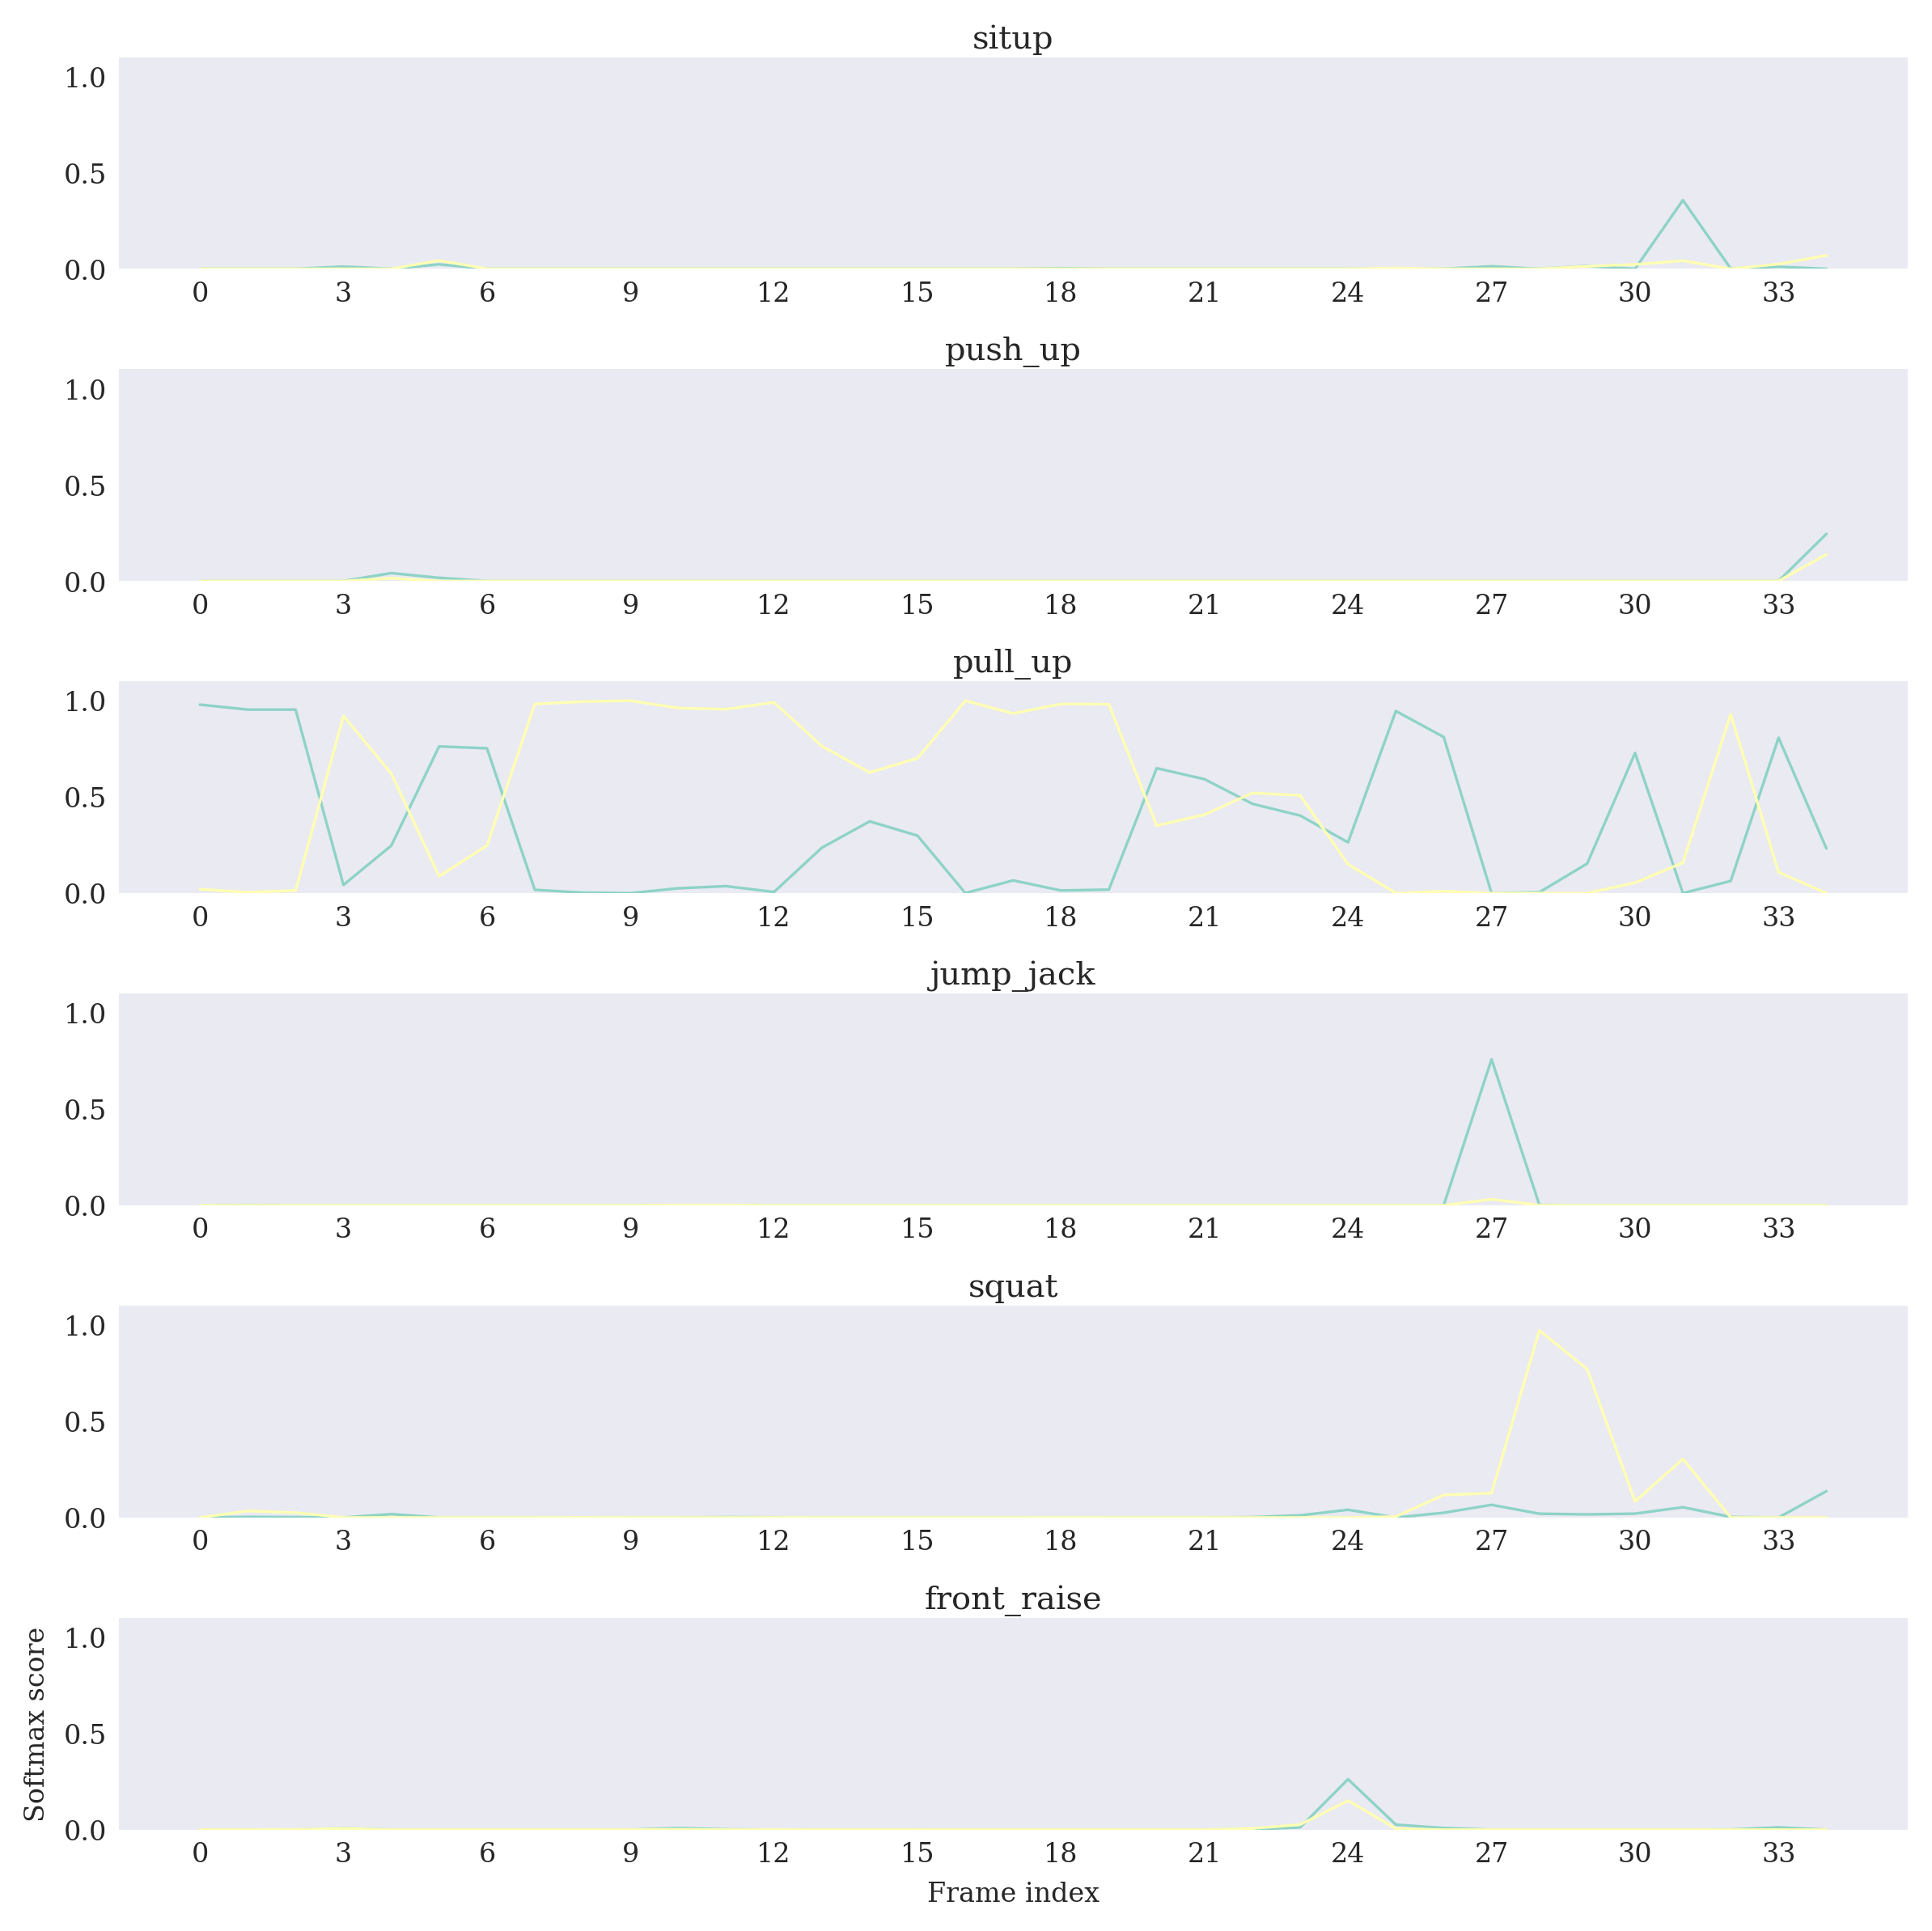

In [191]:
gt_reps = np.array(j['ground_truth'])
counts = len(gt_reps) // 2
axis_x = list(map(int, j['scores'].keys()))
step = axis_x[1] - axis_x[0] # step: 8 frames
total_frames = j['total_frames']
values = list(j['scores'].values())
ys = []
for item in values:
    ys.append([item[str(j)] if str(j) in item else 0 for j in range(12)])
ys = np.asarray(ys)
ys = ys #
print(ys.shape, total_frames)

GT_CLASS_INDEX = CLASSES.index(j['action'])

plt.plot(ys, marker='.', linestyle='None')
plt.xticks(range(0, total_frames//8, total_frames//80))
plt.xlabel('Frame index')
plt.ylabel('Softmax score')
plt.title(f"{j['video_name']} {j['action']} count={counts}")
plt.ylim(0, 1.1)
plt.vlines(x=gt_reps[0::2]//8, color=COLORS[GT_CLASS_INDEX*2], ymin=0.51, ymax=1.0)
plt.vlines(x=gt_reps[1::2]//8, color=COLORS[GT_CLASS_INDEX*2+1], ymin=0.0, ymax=0.49)
plt.legend(np.array(CLASSES).repeat(2))

# Indicator

segs = []
HEIGHT = 1.01
for i in range(len(gt_reps[::2])):
    start = gt_reps[i*2]
    end = gt_reps[i*2+1]
    mid = (start + end) // 2
    segs.append([(start//8, HEIGHT), (mid//8, HEIGHT)])
    segs.append([(mid//8, HEIGHT), (end//8, HEIGHT)])
lc = LineCollection(segs, colors=[COLORS[GT_CLASS_INDEX*2], COLORS[GT_CLASS_INDEX*2+1]], linewidths=1)
plt.gca().add_collection(lc)

plt.show()

fig, ax = plt.subplots(len(CLASSES), 1, figsize=(8, 8))
for idx in range(len(CLASSES)):
    ax[idx].set_ylim(0, 1.1)
    ax[idx].plot(ys[:, idx*2:idx*2+2])
    ax[idx].set_title(f'{CLASSES[idx]}', y=0.95)
    ax[idx].set_xticks(range(0, total_frames//8, total_frames//80))
plt.xlabel('Frame index')
plt.ylabel('Softmax score')
plt.show()

## Count

In [18]:
from workoutdetector.utils.inference_count import pred_to_count

In [189]:
x = next(video_iter)
json_path = x.video_name + '.score.json'
j = json.load(open(osj(video_save_dir, json_path)))
print(j['video_name'])
gt = np.array(j['ground_truth'])
score = j['scores']
threshold = 0.6
# print(score.values())
pred = []

for v in score.values():
    first_item = list(v.items())[0]
    if first_item[1] >= threshold:
        pred.append(int(first_item[0]))
    else:
        pred.append(-1)
print(pred)
result = pred_to_count(pred, step=8)
print(len(gt)//2, result[0], result[1])
print(result[0] == len(gt)//2)

train2542.mp4
[4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, -1, -1, -1, -1, 4, 4, 6, 9, 9, 4, -1, 5, 4, -1]
1 2 [0, 24, 40, 56]
False


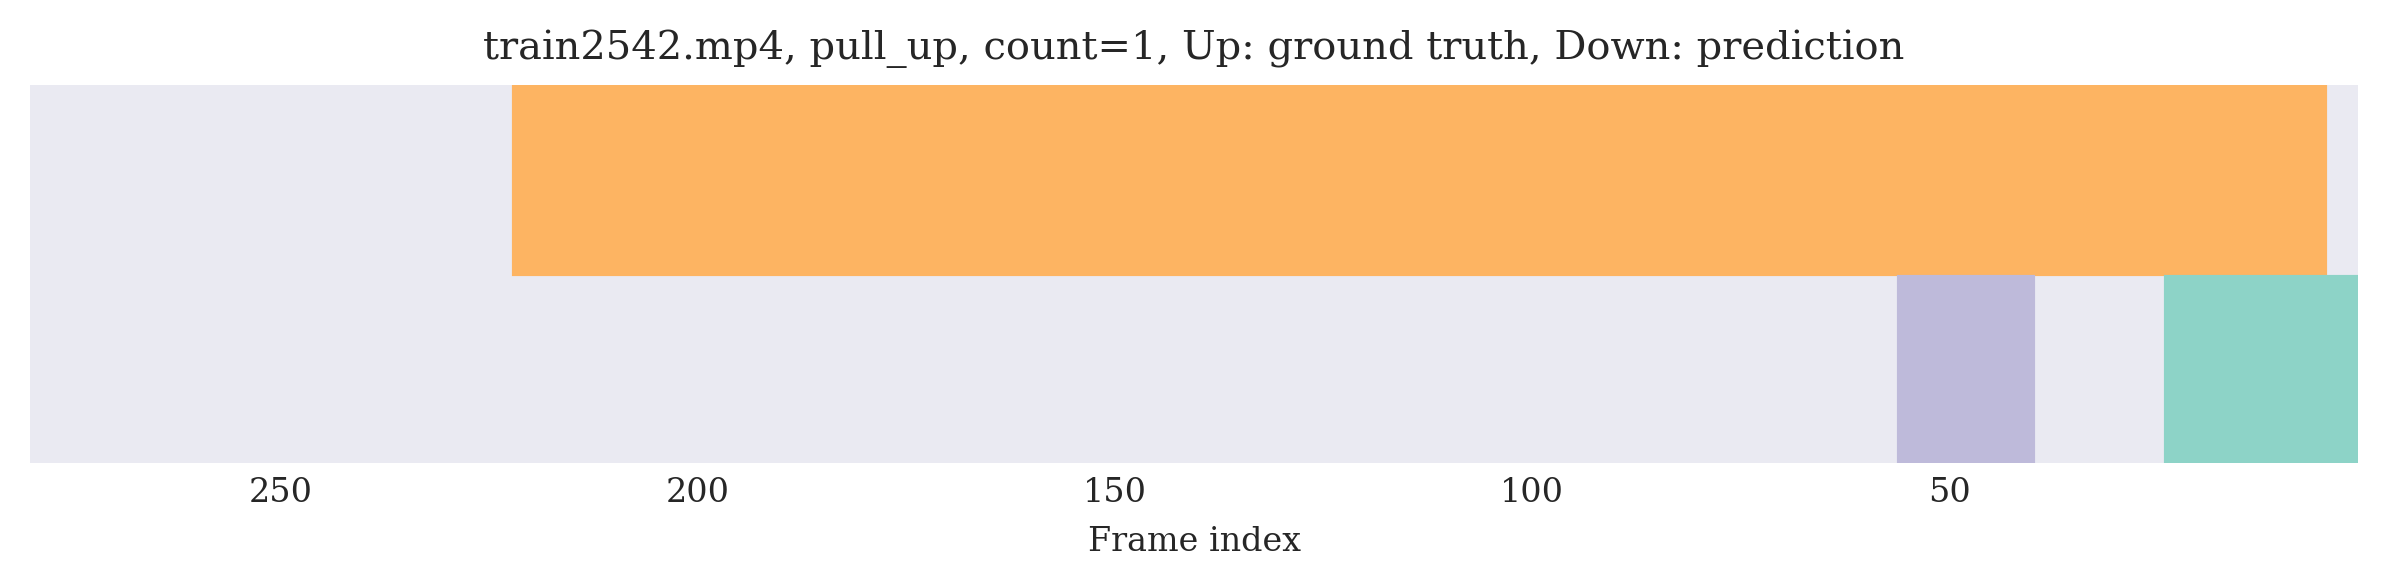

In [190]:
def plot_pred(result, gt, total, info=None, step=8):
    """Plot segmentation result and ground truth."""

    plt.figure(figsize=(8, 2))
    plt.xlabel('Frame index')
    plt.yticks([])
    plt.ylim(0, 1)
    plt.xlim(total)
    for i in range(0, len(gt), 2):
        rect = plt.Rectangle((gt[i], 0.5), (gt[i+1]-gt[i]), 0.5, color=['C5', 'C4'][i%4//2])
        plt.gca().add_patch(rect)
    for j in range(0, len(result), 2):
        rect = plt.Rectangle((result[j], 0.0), (result[j+1]-result[j]), 0.49, color=['C0', 'C2'][j%4//2])
        plt.gca().add_patch(rect)
    # plt.vlines(result, color='C1', ymin=0.0, ymax=1.0)
    plt.title(f'{info["video_name"]}, {info["action"]}, count={len(gt)//2},'\
        ' Up: ground truth, Down: prediction')
    plt.show()
    

plot_pred(result[1], j['ground_truth'], j['total_frames'],j, step=8)